In [1]:
import sys
sys.path.append("/home/julian/repositories")
from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

from barmesh.tribarmes import TriangleBarMesh
tbm = TriangleBarMesh()

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
parapolygraph = ParamPolyGraph(wingshape, "test7.json", splineweight=0.8, legsampleleng=0.003)
# we will extend the urange to the left across 0 to get the overlap between the two wing halves.

In [2]:
parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()
surfacemeshes = [ ]
for i, polynodes in enumerate(polysnodes):
    polyloop = parapolygraph.splinedpolypoints(polynodes)
    polyloopW = [ wingshape.seval(p)  for p in polyloop ]
    surfacemesh = { "polynodes":polynodes, 
                    "polyloop":polyloop,
                    "polyloopW":polyloopW 
                  }
    surfacemeshes.append(surfacemesh)


In [3]:
from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from barmesh import implicitareaballoffset
from wingflatten_barmeshfuncs import MakeRectBarmeshForWingParametrization
from barmesh.barmeshslicer import BarMeshSlicer
from barmesh.mainfunctions import nodewithinpairs, BarMeshContoursN
from barmesh.basicgeo import I1, Partition1


def barmeshoffset(polyloop, polyloopW, radoffset, uspacing, vspacing):
    tbm = TriangleBarMesh()
    polyloopN = [ tbm.NewNode(p)  for p in polyloopW ]
    for i in range(len(polyloopN)-1):
        tbm.bars.append(TriangleBar(polyloopN[i], polyloopN[i+1]))
    tbm.bars.append(TriangleBar(polyloopN[0], polyloopN[-1]))
    iaoffset = implicitareaballoffset.ImplicitAreaBallOffset(tbm)

    urg, vrg = I1.AbsorbList(p[0]  for p in polyloop), I1.AbsorbList(p[1]  for p in polyloop)
    urg = I1(max(urg.lo-0.1, wingshape.urange[0]), min(urg.hi+0.1, wingshape.urange[1]))
    vrg = I1(max(vrg.lo-0.1, wingshape.vrange[0]), min(vrg.hi+0.1, wingshape.vrange[1]))
    urg = I1(urg.lo-0.1, urg.hi+0.1)
    vrg = I1(vrg.lo-0.1, vrg.hi+0.1)

    xpart = Partition1(urg.lo, urg.hi, int(urg.Leng()/uspacing + 2))
    ypart = Partition1(vrg.lo, vrg.hi, int(vrg.Leng()/vspacing + 2))

    bm = MakeRectBarmeshForWingParametrization(wingshape, xpart, ypart)
    rd2 = max(uspacing, vspacing, radoffset*2) + 0.01
    contourdelta = min(uspacing, vspacing)*0.2
    bms = BarMeshSlicer(bm, iaoffset, rd=radoffset, rd2=rd2, contourdotdiff=0.95, contourdelta=contourdelta, lamendgap=0.001, strictlyplanarbarmesh=False)

    #bms.initializecutsanddistances()
    bms.fullmakeslice()
    return bm

for i in range(len(surfacemeshes)):
    print("\nStarting", i)
    surfacemesh = surfacemeshes[i]
    polyloop, polyloopW = surfacemesh["polyloop"], surfacemesh["polyloopW"]
    surfacemesh["barmeshoffset"] = barmeshoffset(polyloop, polyloopW, radoffset=0.006, uspacing=0.02, vspacing=0.02)



Starting 0
make triangle boxing at 0.047043302883781335
MakePointZoneRFS done on 5170 nodes
do splitbarsdirectionchangesR on 10183 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  460
nsegs: 486 bad: 0 working: 0
130 [30, 30, 15, 10, 0, 15, 20, 10, 0, 0, 0, 0, 0]

Starting 1
make triangle boxing at 0.04245011031816404
MakePointZoneRFS done on 9044 nodes
do splitbarsdirectionchangesR on 17812 bars
do splitbarsdirectionchangesR on 18502 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  958
nsegs: 984 bad: 0 working: 0
121 [20, 29, 10, 10, 22, 15, 5, 0, 5, 5, 0, 0, 0, 0, 0]

Starting 2
make triangle boxing at 0.052358552582613564
MakePointZoneRFS done on 3196 nodes
do splitbarsdirectionchangesR on 6277 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  292
nsegs: 317 bad: 0 working: 0
122 [27, 25, 15, 10, 0, 20, 15, 0, 0, 5, 5, 0, 0, 0, 0, 0]

Starting 3
make triangle boxing at 0.019120965004800473
MakePointZoneRFS done on 16422 nodes
do sp

In [7]:
from barmesh.mainfunctions import NestContours, BarMeshContoursN
from barmesh import barmesh

for i in range(len(surfacemeshes)):
    print(i)
    surfacemesh = surfacemeshes[i]
    bm = surfacemesh["barmeshoffset"]
    contsN, topbars = BarMeshContoursN(bm, barmesh.PZ_BEYOND_R)
    contnest = NestContours(topbars, barmesh.PZ_BEYOND_R)
    mconts = dict((topbar.midcontournumber, cont)  for cont, topbar in zip(contsN, topbars))
    outerconts = [mconts[cn]  for cn, (izone, outxn, innlist) in contnest.items()  if izone == barmesh.PZ_BEYOND_R and outxn == -1]
    if outerconts:
        outercont = outerconts[0]
        outercont.append(outercont[0])
        surfacemesh["offsetloopuv"] = [n.sp for n in outercont]
        surfacemesh["offsetlooppts"] = [n.p for n in outercont]
    else:
        print("Missing outer conts on", i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<IPython.core.display.Javascript object>


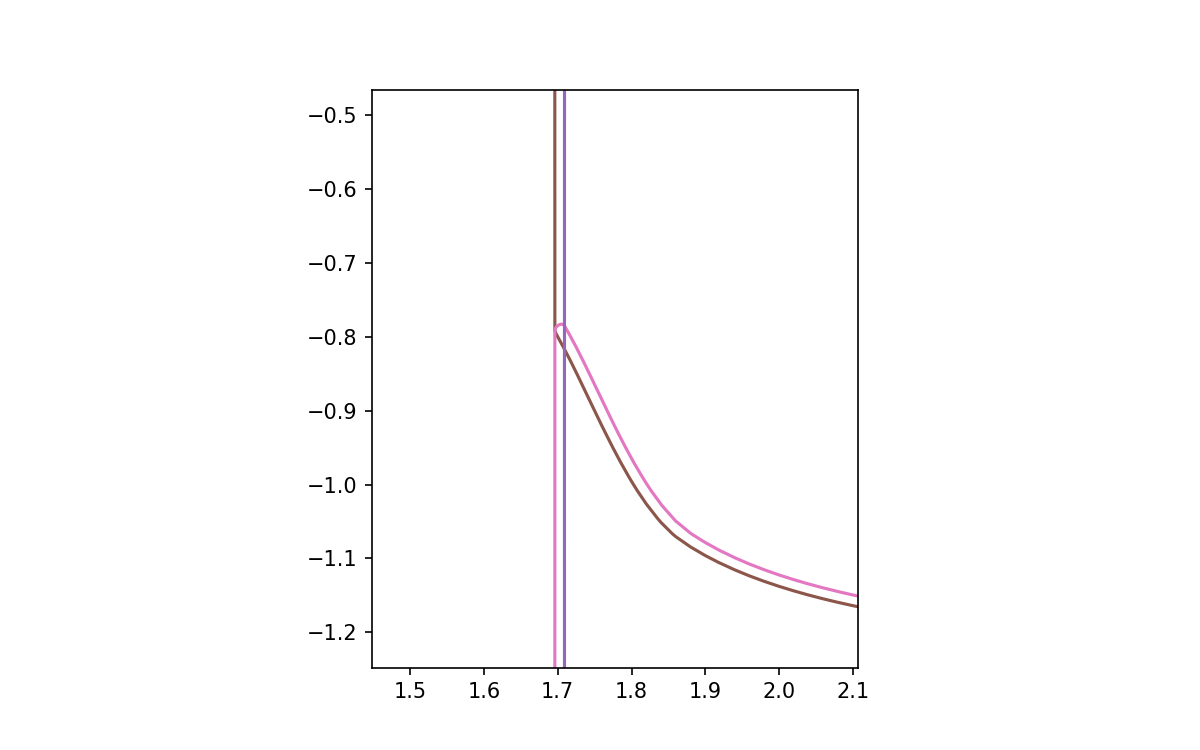

In [15]:
%matplotlib notebook 

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(8,5))
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    sps = surfacemesh["offsetloopuv"]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps])
plt.gca().autoscale()
plt.gca().set_aspect("equal")


<IPython.core.display.Javascript object>


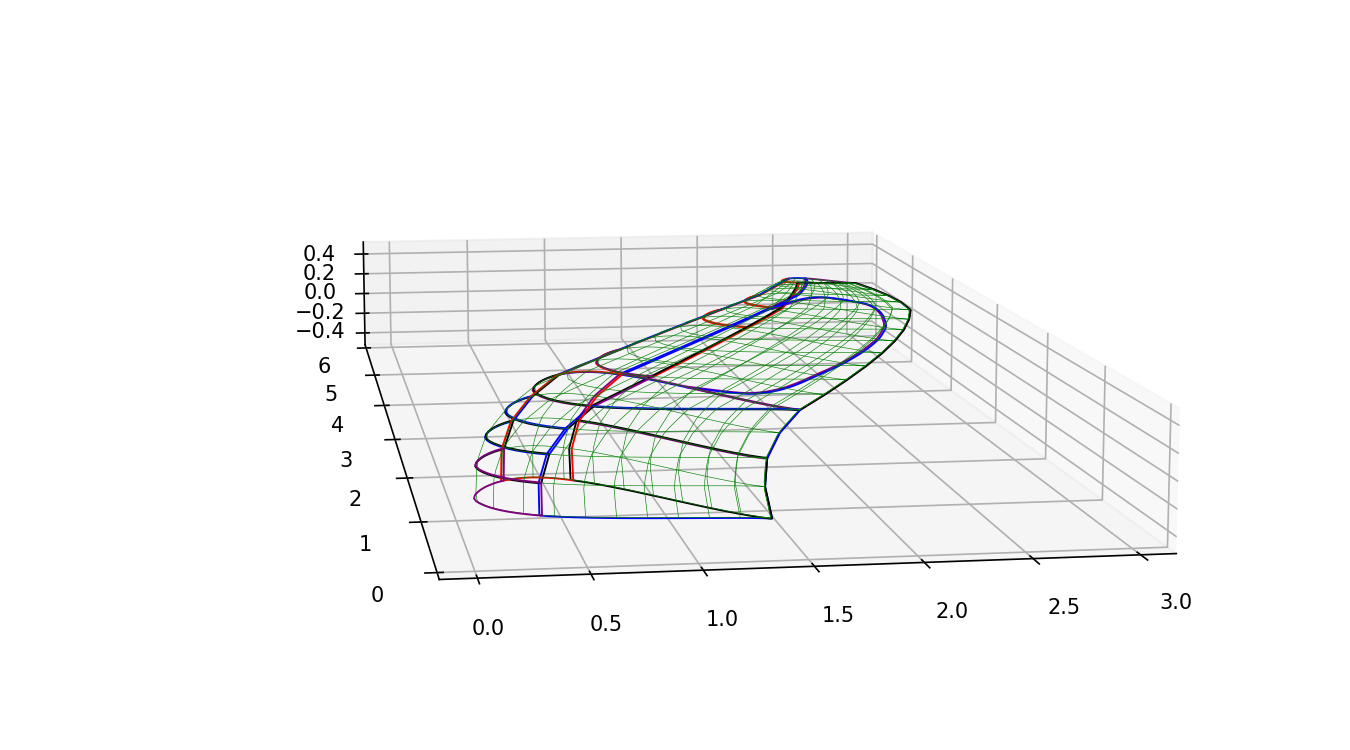

(0.0, 6.0)

In [14]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return (p.x, p.z, p.y)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

ax3d.add_collection(Line3DCollection(wingshape.linesegmentnetflipyz(flipyz), color="green", linewidth=0.3))

cols = ["red", "blue", "purple", "black"]
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    ps = surfacemesh["offsetlooppts"]
    segpolys = [ ]
    segpolys.append([flipyz(p)  for p in ps])
    lp3d = Line3DCollection(segpolys, color=cols[0], linewidth=0.9)
    ax3d.add_collection(lp3d)
    cols = cols[1:]+[cols[0]]
ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)

In [10]:
parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()

polynodes = polysnodes[2]
polyloop = parapolygraph.splinedpolypoints(polynodes)
polyloopW = [ wingshape.seval(p)  for p in polyloop ]


In [11]:
%matplotlib notebook 

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
segments = [[(bar.nodeback.p[0], bar.nodeback.p[1]), (bar.nodefore.p[0], bar.nodefore.p[1])]  for bar in bm.bars  if not bar.bbardeleted ]
lc = LineCollection(segments)

plt.figure()
plt.gca().add_collection(lc)
plt.gca().autoscale()
plt.gca().set_aspect("equal")


NameError: name 'bm' is not defined

In [12]:
parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()


In [9]:
parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()
polynodes = polysnodes[2]
polyloop = parapolygraph.splinedpolypoints(polynodes)
polyloopW = [ wingshape.seval(p)  for p in polyloop ]


In [10]:
from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
tbm = TriangleBarMesh()
polyloopN = [ tbm.NewNode(p)  for p in polyloopW ]
for i in range(len(polyloopN)-1):
    tbm.bars.append(TriangleBar(polyloopN[i], polyloopN[i+1]))
tbm.bars.append(TriangleBar(polyloopN[0], polyloopN[-1]))
    

In [11]:
from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
tbm = TriangleBarMesh()
polyloopN = [ tbm.NewNode(p)  for p in polyloopW ]
for i in range(len(polyloopN)-1):
    tbm.bars.append(TriangleBar(polyloopN[i], polyloopN[i+1]))
tbm.bars.append(TriangleBar(polyloopN[0], polyloopN[-1]))

#from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from barmesh import implicitareaballoffset
iaoffset = implicitareaballoffset.ImplicitAreaBallOffset(tbm)


make triangle boxing at 0.052358552582613564


In [12]:
len(bm.bars)

85792

In [13]:
from barmesh.barmeshslicer import BarMeshSlicer

rad = 0.01
rd2 = max(uspacing, vspacing, rad*2) + 0.01
bms = BarMeshSlicer(bm, iaoffset, rd=rad, rd2=rd2, contourdotdiff=0.95, contourdelta=0.001, lamendgap=0.001, strictlyplanarbarmesh=False)

#bms.initializecutsanddistances()
bms.fullmakeslice()


MakePointZoneRFS done on 43120 nodes
do splitbarsdirectionchangesR on 85792 bars
do splitbarsdirectionchangesR on 85796 bars
done splitbarsdirectionchangesR
Ready fo barpolycutsrounds  290
nsegs: 372 bad: 0 working: 0
380 [72, 42, 55, 13, 0, 68, 23, 31, 15, 0, 28, 8, 5, 10, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


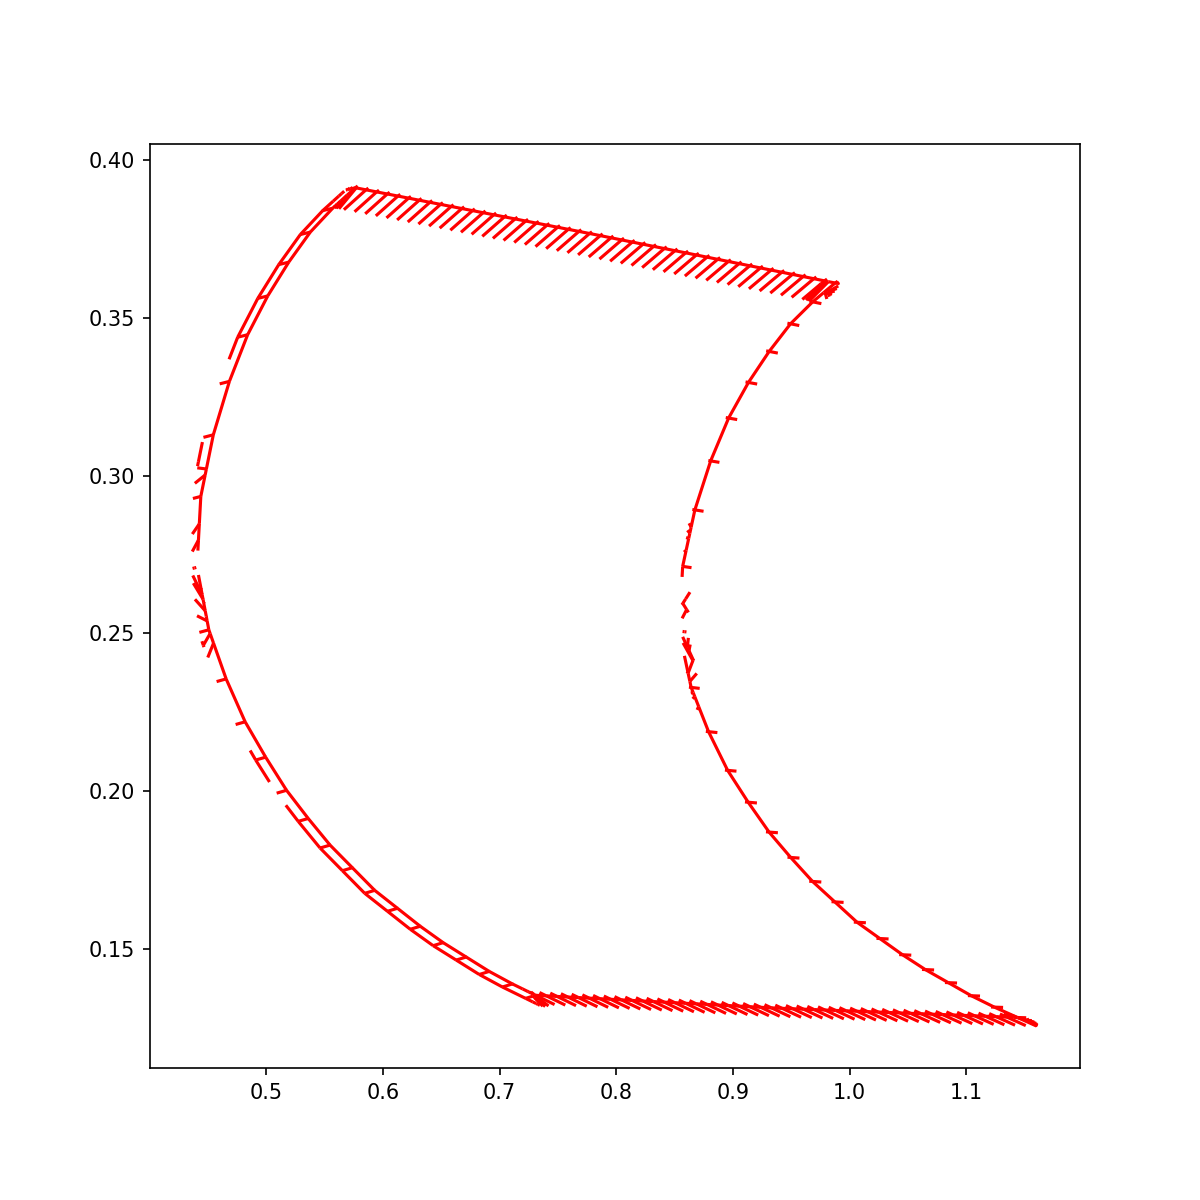

In [16]:

from barmesh.mainfunctions import nodewithinpairs

plt.figure(figsize=(8,8))

segmentswithin = [ [(n0.p[0], n0.p[1]), (n1.p[0], n1.p[1])]  for n0, n1 in nodewithinpairs(bm, True) ]
lc = LineCollection(segmentswithin, color="red")
plt.gca().add_collection(lc)

segmentsbeyond = [ [(n0.p[0], n0.p[1]), (n1.p[0], n1.p[1])]  for n0, n1 in nodewithinpairs(bm, False) ]
lc = LineCollection(segmentsbeyond, color="blue")
#plt.gca().add_collection(lc)

plt.gca().autoscale()



<IPython.core.display.Javascript object>


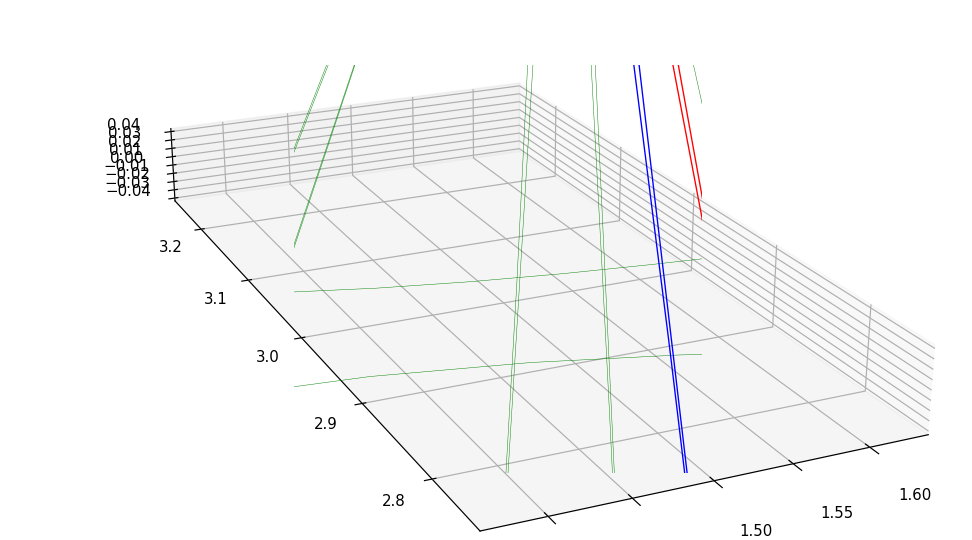

(0.0, 6.0)

In [21]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return P3(p.x, p.z, p.y)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

ax3d.add_collection(Line3DCollection(wingshape.linesegmentnetflipyz(flipyz), color="green", linewidth=0.3))

col = "red"
for k in sorted(mconts.keys()):
    segpolys = [ ]
    segpolys.append([flipyz(p)  for p in mconts[k]])
    segpolys[-1].append(segpolys[-1][0])
    lp3d = Line3DCollection(segpolys, color=col, linewidth=0.9)
    ax3d.add_collection(lp3d)
    col = "blue"

ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)